In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np
from scipy.stats import sem
from scipy.stats import sem
import os

plt.rcParams["axes.xmargin"] = 0

In [2]:
# !pip install scipy

In [3]:
def get_sweeps(project):
    sweeps = []
    for sweep in project:
        sweeps.append((sweep.name, sweep.id))
    return sweeps[::-1]


def get_run_links(sweeps, project_name):
    runs = []
    for sweep_name, sweep_link in sweeps:
        sweep = wandb.Api().sweep(f"lucacorbucci/{project_name}/{sweep_link}")
        run_list_sweep = []
        for run in sweep.runs:
            run_list_sweep.append(run.id)
        runs.append((sweep_name, run_list_sweep[::-1]))
    return runs


def get_run_data(run_links_per_sweep, project_name):
    run_data = []
    for sweep_name, sweep in run_links_per_sweep:
        print("Downloading data for a sweep")
        tmp_run_data = []
        for run_link in sweep:
            run = wandb.Api().run(f"lucacorbucci/{project_name}/{run_link}")

            tmp_run_data.append(pd.DataFrame(run.scan_history()))
        run_data.append((sweep_name, tmp_run_data))
    return run_data


def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df


def create_avg_dataset(new_list):
    # print(new_list)
    # compute the mean and the std of the data in new_list
    # and create a new dataset with these values
    mean = []
    std = []
    dots_lenght = len(new_list[0])
    for dots in range(dots_lenght):
        current_values = []
        for item in new_list:
            if item[dots] > 0:
                current_values.append(item[dots])
        current_mean = np.mean(current_values)           
        mean.append(current_mean)
        current_std = np.std(current_values, axis=0) #sem(current_values)
        std.append(current_std)
    # std = sem(new_list)  # np.std(new_list, axis=0)

    df = pd.DataFrame()
    dots_list = []
    increasing_mean = []
    current_max = 0
    new_std = []
    previous_std = -1
    previous_mean = -1
    for value_mean, value_std  in zip(mean, std):
        if value_mean > current_max:
            current_max = value_mean
            dots_list.append(current_max)
        else:
            dots_list.append(None)
        
        if value_mean >= previous_mean:
            new_std.append(value_std)
            increasing_mean.append(value_mean)
            previous_mean = value_mean
            previous_std = value_std
        else:
            new_std.append(previous_std)
            increasing_mean.append(previous_mean)
        
    df["mean"] = increasing_mean #mean
    df["dots"] = dots_list
    df["std"] = new_std # std
    df["index"] = list(range(0, len(mean)))
    return df



def prepare_pareto_frontier(data_lists):
    custom_metrics = []

    for data_list in data_lists:
        tmp_custom_metrics = []
        current_max = 0
        for value in data_list:
            if value >= current_max:
                current_max = value
            tmp_custom_metrics.append(current_max)
        custom_metrics.append(copy.deepcopy(tmp_custom_metrics))

    return custom_metrics


def extract_last_custom_metrics(sweep, expected_len):
    custom_metrics = []
    for sweep_dfs in sweep:
        tmp_custom_metrics = []
        for df in sweep_dfs:
            custom_metric = remove_nan(["Custom_metric"], df)
            last_value = custom_metric.values.tolist()[-1][0]
            if last_value == "-Infinity":
                last_value = 0
            if len(custom_metric) != expected_len:
                last_value = 0
            tmp_custom_metrics.append(last_value)
        custom_metrics.append(tmp_custom_metrics)
    return custom_metrics


# Functions to plot
def plot_pareto_frontier(mean_df_tunable, mean_df_fixed, name, target, epsilon):
    plt.figure(figsize=(15, 10))

    # Plot mean as a line
    plt.plot(
        mean_df_tunable["index"],
        mean_df_tunable["mean"],
        label="Tunable Lambda",
        color="blue",
    )
    plt.plot(
        mean_df_fixed["index"],
        mean_df_fixed["mean"],
        label="Fixed Lambda",
        color="green",
    )

    # Plot dots for non-None values in "dots" column
    dots_mask = mean_df_tunable["dots"].notnull()
    plt.scatter(
        mean_df_tunable["index"][dots_mask],
        mean_df_tunable["dots"][dots_mask],
        color="blue",
        marker="o",
    )

    dots_mask = mean_df_fixed["dots"].notnull()
    plt.scatter(
        mean_df_fixed["index"][dots_mask],
        mean_df_fixed["dots"][dots_mask],
        color="green",
        marker="o",
    )

    # Plot std as shaded area
    plt.fill_between(
        mean_df_tunable["index"],
        mean_df_tunable["mean"] - mean_df_tunable["std"],
        mean_df_tunable["mean"] + mean_df_tunable["std"],
        alpha=0.2,
        color="blue",
    )

    plt.fill_between(
        mean_df_fixed["index"],
        mean_df_fixed["mean"] - mean_df_fixed["std"],
        mean_df_fixed["mean"] + mean_df_fixed["std"],
        alpha=0.2,
        color="green",
    )

    # Customize the plot
    plt.title(f"Fixed vs Tunable - Target {target} - Eps {epsilon}")
    plt.xlabel("Experiments")
    plt.ylabel("Maximixed Metric")
    plt.rcParams.update({"font.size": 30})
    plt.ylim(0, 1)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"./plots_paper/Dutch/{name}_std.png")
    plt.show()


def plot(project_name):
    project = wandb.Api().project(project_name).sweeps()
    sweeps = get_sweeps(project)
    run_links = get_run_links(sweeps, project_name)
    data = get_run_data(
        run_links,
        project_name,
    )
    tunable = [df for name, df in data if name == "prob_tunable_private"]
    fixed = [df for name, df in data if name == "prob_fixed_private"]
    custom_metrics_tunable = extract_last_custom_metrics(tunable)
    custom_metrics_fixed = extract_last_custom_metrics(fixed)
    pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable)
    pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed)
    df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
    df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
    plot_pareto_frontier(df_pareto_tunable, df_pareto_fixed, project_name)


def prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train",
    disparity_experiments_type="Training",
):
    tunable_train_accuracy = []
    tunable_train_disparity = []
    for experiment in tunable_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        tunable_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        tunable_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    fixed_train_accuracy = []
    fixed_train_disparity = []
    for experiment in fixed_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        fixed_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        fixed_train_disparity.append(list(experiment[disparity_experiments_type])[0:40])

    fixed_mean_train_accuracy = np.mean(fixed_train_accuracy, axis=0)
    fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
    if len(fixed_train_accuracy) > 1:
        fixed_std_train_accuracy = sem(
            fixed_train_accuracy
        )  # np.std(fixed_train_accuracy, axis=0)
        fixed_std_train_disparity = sem(
            fixed_train_disparity
        )  # np.std(fixed_train_disparity, axis=0)
    else:
        fixed_std_train_accuracy = fixed_train_accuracy
        fixed_std_train_disparity = fixed_train_disparity

    # for item in tunable_train_accuracy:
    #     print(len(item))
    tunable_mean_train_accuracy = np.mean(tunable_train_accuracy, axis=0)
    tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
    if len(tunable_train_accuracy) > 1:
        tunable_std_train_accuracy = sem(
            tunable_train_accuracy
        )  # np.std(tunable_train_accuracy, axis=0)
        tunable_std_train_disparity = sem(
            tunable_train_disparity
        )  # np.std(tunable_train_disparity, axis=0)
    else:
        tunable_std_train_accuracy = tunable_train_accuracy
        tunable_std_train_disparity = tunable_train_disparity

    baseline_train_accuracy = []
    baseline_train_disparity = []
    for experiment in baseline_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        baseline_train_accuracy.append(
            list(experiment[accuracy_experiments_type])[0:40]
        )
        baseline_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    baseline_mean_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_mean_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    if len(baseline_experiments) > 0:
        baseline_mean_train_accuracy = np.mean(baseline_train_accuracy, axis=0)
        baseline_mean_train_disparity = np.mean(baseline_train_disparity, axis=0)

        if len(baseline_train_disparity) > 1:
            baseline_std_train_disparity = sem(
                baseline_train_disparity
            )  # np.std(baseline_train_disparity, axis=0)
        else:
            baseline_std_train_disparity = baseline_mean_train_disparity
        if len(baseline_train_accuracy) > 1:
            baseline_std_train_accuracy = sem(
                baseline_train_accuracy
            )  # np.std(baseline_train_accuracy, axis=0)
        else:
            baseline_std_train_accuracy = baseline_mean_train_accuracy

    return (
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    )


def plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_name,
    target,
    epsilon,
    experiment_type="Train",
    num_rounds=39,
    std=True,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(x, tunable_mean_train_accuracy, label="Tunable", color="blue", linewidth=3)
    plt.plot(x, fixed_mean_train_accuracy, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_accuracy == 0).all():
        plt.plot(
            x, baseline_mean_train_accuracy, label="Baseline", color="red", linewidth=3
        )

    # compare the two numpy arrays with all the values
    if std and not (baseline_mean_train_accuracy == baseline_std_train_accuracy).all():
        plt.fill_between(
            x,
            baseline_mean_train_accuracy - baseline_std_train_accuracy,
            baseline_mean_train_accuracy + baseline_std_train_accuracy,
            alpha=0.2,
            color="red",
        )

    if std and not (tunable_mean_train_accuracy == tunable_std_train_accuracy).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_accuracy - tunable_std_train_accuracy,
            tunable_mean_train_accuracy + tunable_std_train_accuracy,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_accuracy == fixed_std_train_accuracy).all():
        plt.fill_between(
            x,
            fixed_mean_train_accuracy - fixed_std_train_accuracy,
            fixed_mean_train_accuracy + fixed_std_train_accuracy,
            alpha=0.2,
            color="green",
        )

    plt.ylim(0, 1)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 30})

    plt.ylabel("Accuracy")
    plt.title(
        f"{experiment_type} Acc."
        + ("- Mean & Std. Err." if std else "")
        + f" - Target {target} - Eps {epsilon}"
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"./plots_paper/Dutch/accuracy_{experiment_type}_{experiment_name}.png")

    plt.show()


def plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_name,
    target,
    epsilon,
    experiment_type,
    num_rounds=39,
    std=True,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(
        x, tunable_mean_train_disparity, label="Tunable", color="blue", linewidth=3
    )
    plt.plot(x, fixed_mean_train_disparity, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_disparity == 0).all():
        plt.plot(
            x, baseline_mean_train_disparity, label="Baseline", color="red", linewidth=3
        )

    if (
        std
        and not (baseline_mean_train_disparity == baseline_std_train_disparity).all()
    ):
        plt.fill_between(
            x,
            baseline_mean_train_disparity - baseline_std_train_disparity,
            baseline_mean_train_disparity + baseline_std_train_disparity,
            alpha=0.2,
            color="red",
        )
    if std and not (tunable_mean_train_disparity == tunable_std_train_disparity).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_disparity - tunable_std_train_disparity,
            tunable_mean_train_disparity + tunable_std_train_disparity,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_disparity == fixed_std_train_disparity).all():
        plt.fill_between(
            x,
            fixed_mean_train_disparity - fixed_std_train_disparity,
            fixed_mean_train_disparity + fixed_std_train_disparity,
            alpha=0.2,
            color="green",
        )

    # horizontal line indicating the target between 0 and num-rounds
    plt.axhline(
        y=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
        xmin=0,
        xmax=num_rounds,
    )
    plt.ylim(0, 0.3)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 30})

    plt.ylabel("Disparity")
    plt.title(
        f"{experiment_type} Disp."
        + ("- Mean & Std. Err." if std else "")
        + f" - Target {target} - Eps {epsilon}"
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()

    plt.savefig(
        f"./plots_paper/Dutch/disparity_{experiment_type}_{experiment_name}.png"
    )
    plt.show()


def get_best_run(dfs):
    custom_metrics = extract_last_custom_metrics(dfs, expected_len=39)
    # get the index of the best run
    best_runs_index = []
    for sweep in custom_metrics:
        index = np.argmax(sweep)
        best_runs_index.append(index)
    best_runs = []
    for df, index in zip(dfs, best_runs_index):
        df = df[index]
        best_runs.append(df)
    return best_runs


def get_accuracy_and_disparity(best_runs, accuracy_column_name, disparity_column_name):
    accuracy = []
    disparity = []
    for run in best_runs:
        accuracy.append(run[accuracy_column_name])
        disparity.append(run[disparity_column_name])
    return accuracy, disparity


def download_data(project_name):
    # project_name = "Dutch_Baseline_1"
    # check if we don't want to download the data again
    if not os.path.exists(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl"):
        # plot(project_name)
        project = wandb.Api().project(project_name).sweeps()
        sweeps = get_sweeps(project)
        run_links = get_run_links(sweeps, project_name)
        data = get_run_data(
            run_links,
            project_name,
        )
        with open(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "wb") as f:
            dill.dump(data, f)
    else:
        with open(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "rb") as f:
            data = dill.load(f)
    return data


def plot_accuracy_and_disparity(
    experiment_type,
    accuracy_experiments_type,
    disparity_experiments_type,
    experiment_name,
    target,
    best_runs_tunable,
    best_runs_fixed,
    best_run_baseline,
    epsilon,
):
    (
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    ) = prepare_mean_and_std(
        best_runs_tunable,
        best_runs_fixed,
        best_run_baseline,
        accuracy_experiments_type=accuracy_experiments_type,
        disparity_experiments_type=disparity_experiments_type,
    )
    plot_accuracy(
        tunable_mean_train_accuracy,
        tunable_std_train_accuracy,
        fixed_mean_train_accuracy,
        fixed_std_train_accuracy,
        baseline_mean_train_accuracy,
        baseline_std_train_accuracy,
        experiment_type=experiment_type,
        experiment_name=experiment_name,
        target=target,
        epsilon=epsilon,
    )
    plot_disparity(
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        baseline_mean_train_disparity,
        baseline_std_train_disparity,
        experiment_type=experiment_type,
        target=target,
        experiment_name=experiment_name,
        epsilon=epsilon,
    )


def manage_plots(data, data_baseline, target, project_name, epsilon):
    tunable = [df for name, df in data if name == "prob_tunable_private"]
    fixed = [df for name, df in data if name == "prob_fixed_private"]
    baseline = [df for name, df in data_baseline]
    custom_metrics_tunable = extract_last_custom_metrics(tunable, expected_len=39)
    custom_metrics_fixed = extract_last_custom_metrics(fixed, expected_len=39)
    pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable)
    pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed)
    df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
    df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
    plot_pareto_frontier(
        df_pareto_tunable, df_pareto_fixed, project_name, target, epsilon
    )
    # best_runs_tunable = get_best_run(tunable)
    # best_runs_fixed = get_best_run(fixed)
    # best_run_baseline = get_best_run(baseline)
    # plot_accuracy_and_disparity(
    #     experiment_type="Train",
    #     accuracy_experiments_type="Train Accuracy",
    #     disparity_experiments_type="Training Disparity with statistics no noise",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )
    # plot_accuracy_and_disparity(
    #     experiment_type="Test",
    #     accuracy_experiments_type="Test Accuracy",
    #     disparity_experiments_type="Test Disparity with statistics",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )
    # plot_accuracy_and_disparity(
    #     experiment_type="Validation",
    #     accuracy_experiments_type="Validation_Accuracy",
    #     disparity_experiments_type="Validation Disparity with statistics",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )

# Baseline Epsilon 1

In [4]:
data_baseline_1 = download_data("Dutch_Baseline_1")

In [5]:
data_baseline_05 = download_data("Dutch_Baseline_05")

# Target 0.05 Epsilon 1

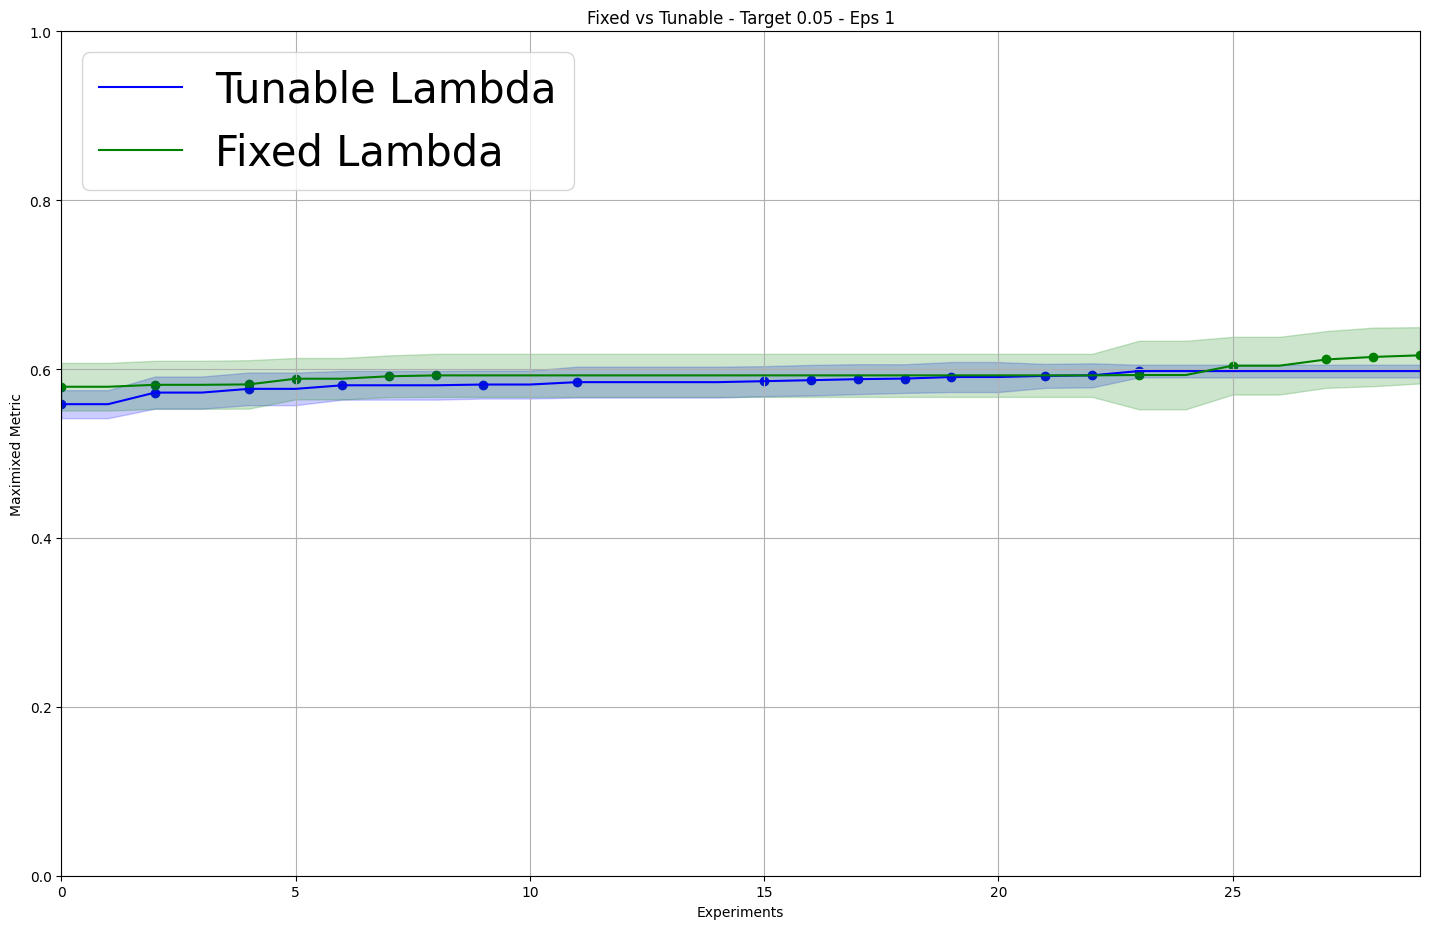

In [6]:
project_name = "Dutch_005_epsilon_1"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_1,
    target=0.05,
    project_name=project_name,
    epsilon=1,
)

# Target 0.05 Epsilon 0.5

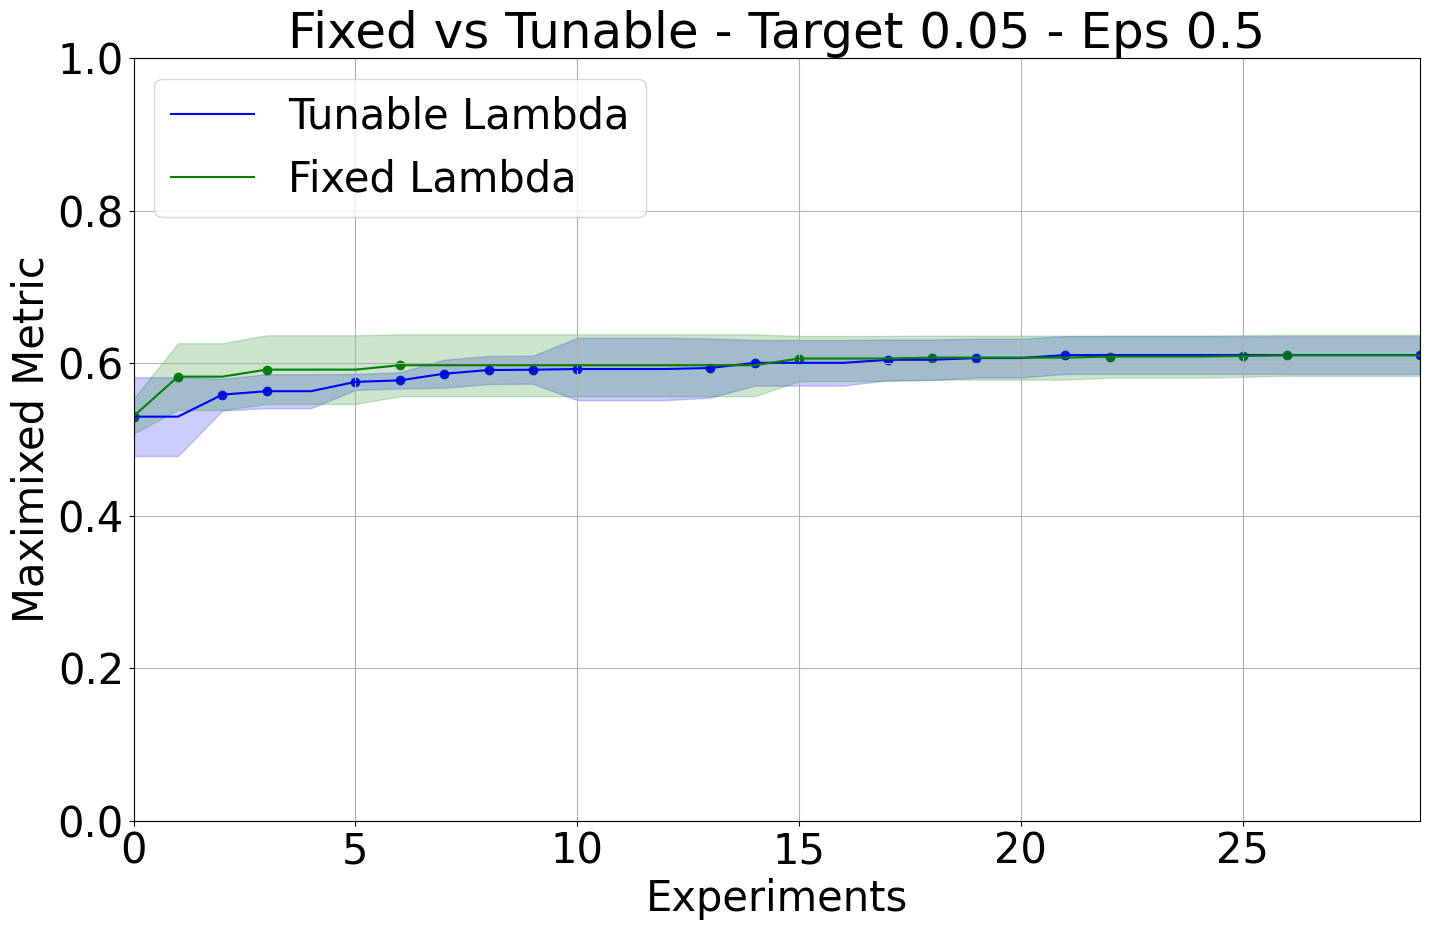

In [7]:
project_name = "Dutch_005_epsilon_05"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_05,
    target=0.05,
    project_name=project_name,
    epsilon=0.5,
)

# Target 0.075 Epsilon 1

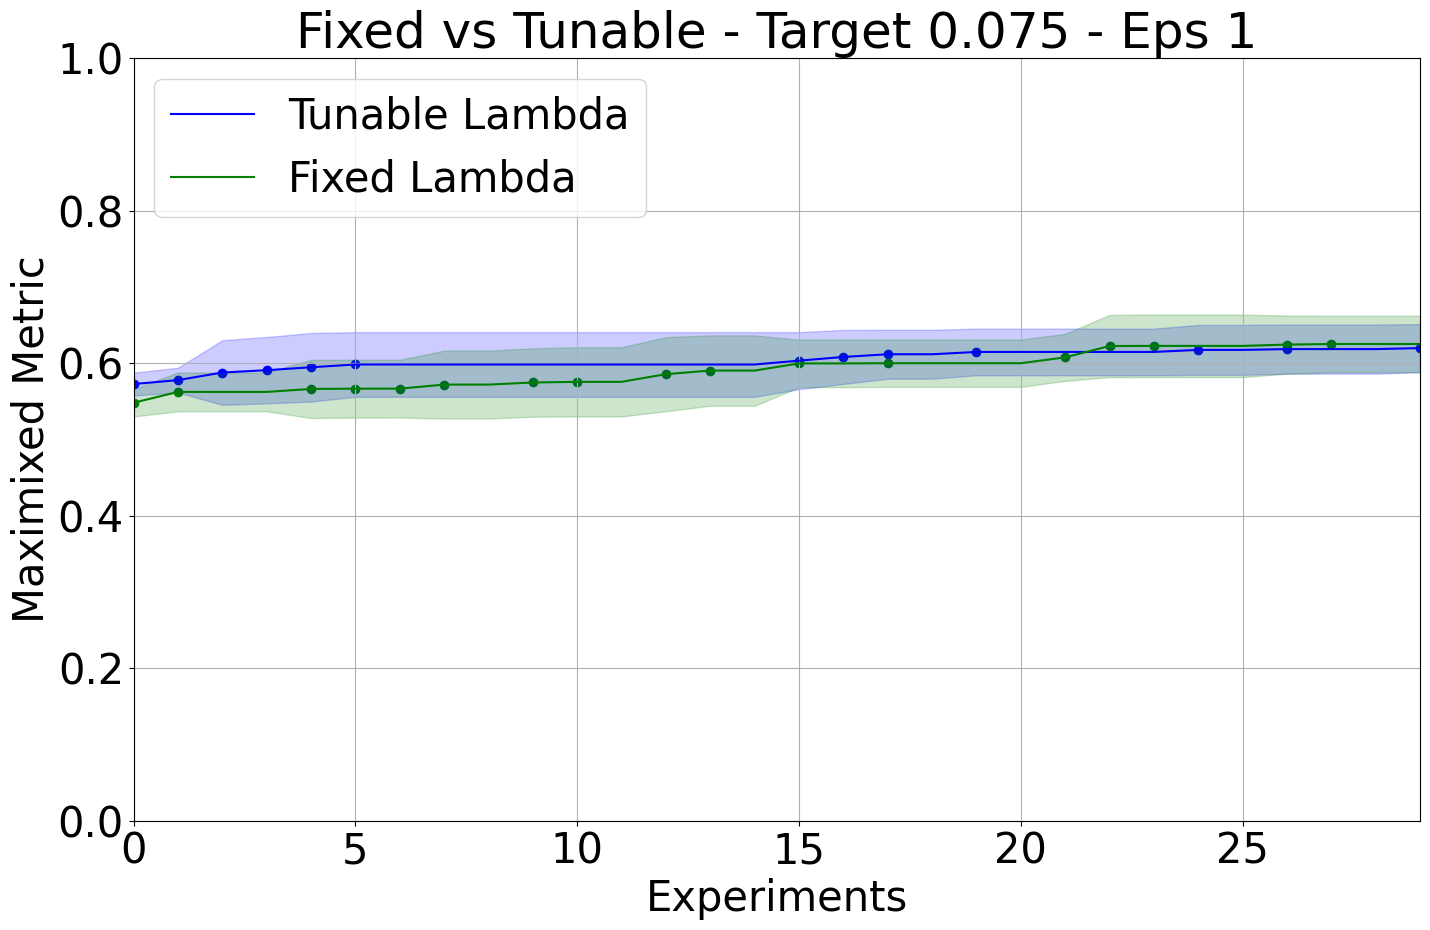

In [8]:
project_name = "Dutch_0075_epsilon_1"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_1,
    target=0.075,
    project_name=project_name,
    epsilon=1,
)

# Target 0.075 Epsilon 0.5

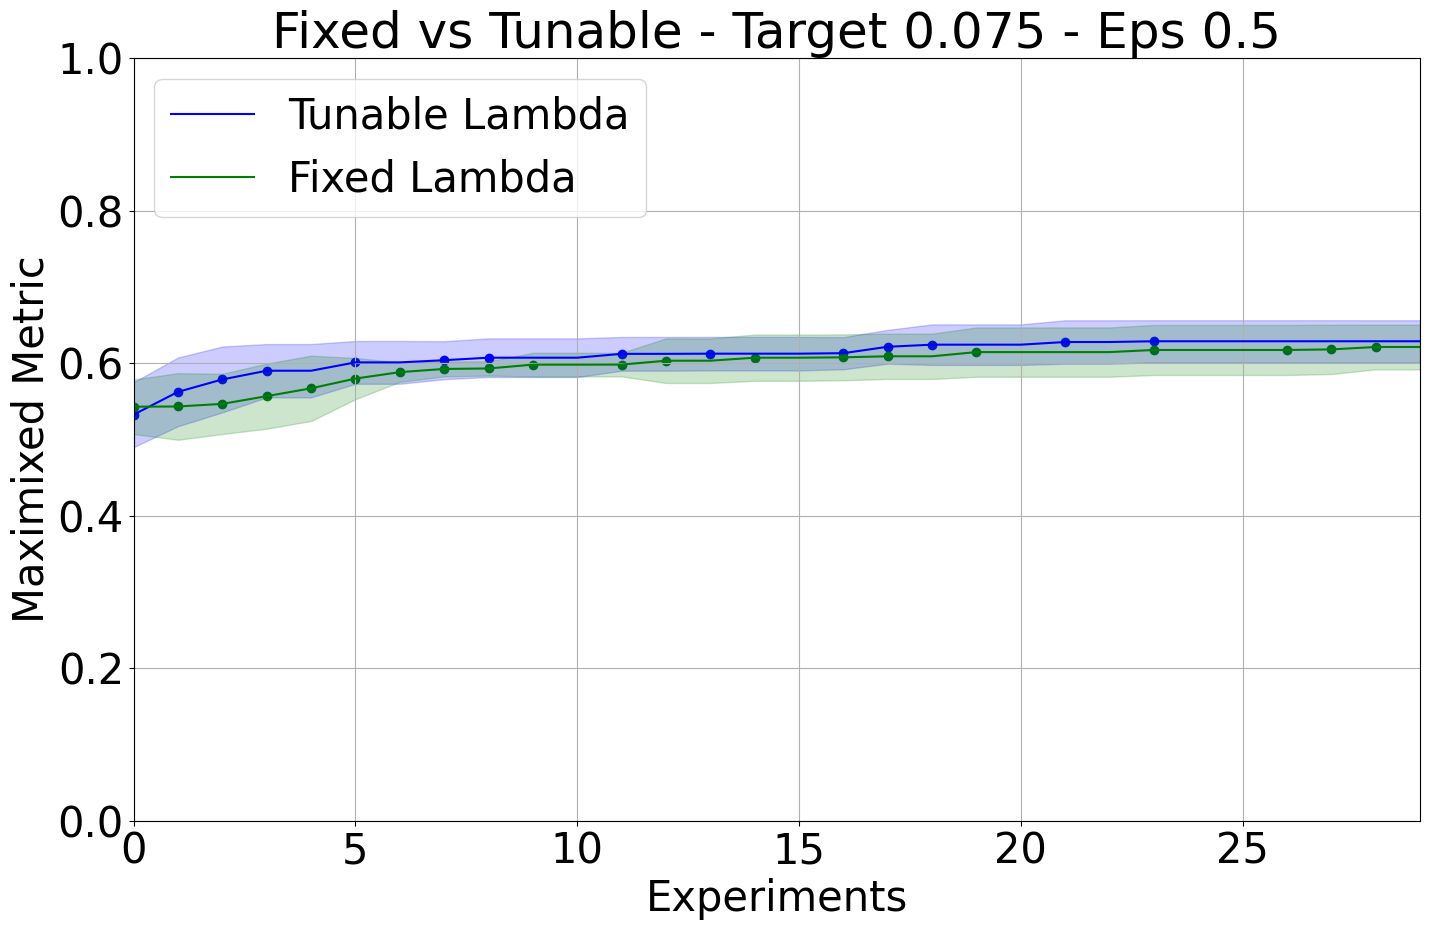

In [9]:
project_name = "Dutch_0075_epsilon_05"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_05,
    target=0.075,
    project_name=project_name,
    epsilon=0.5,
)

# Target 0.1 Epsilon 1

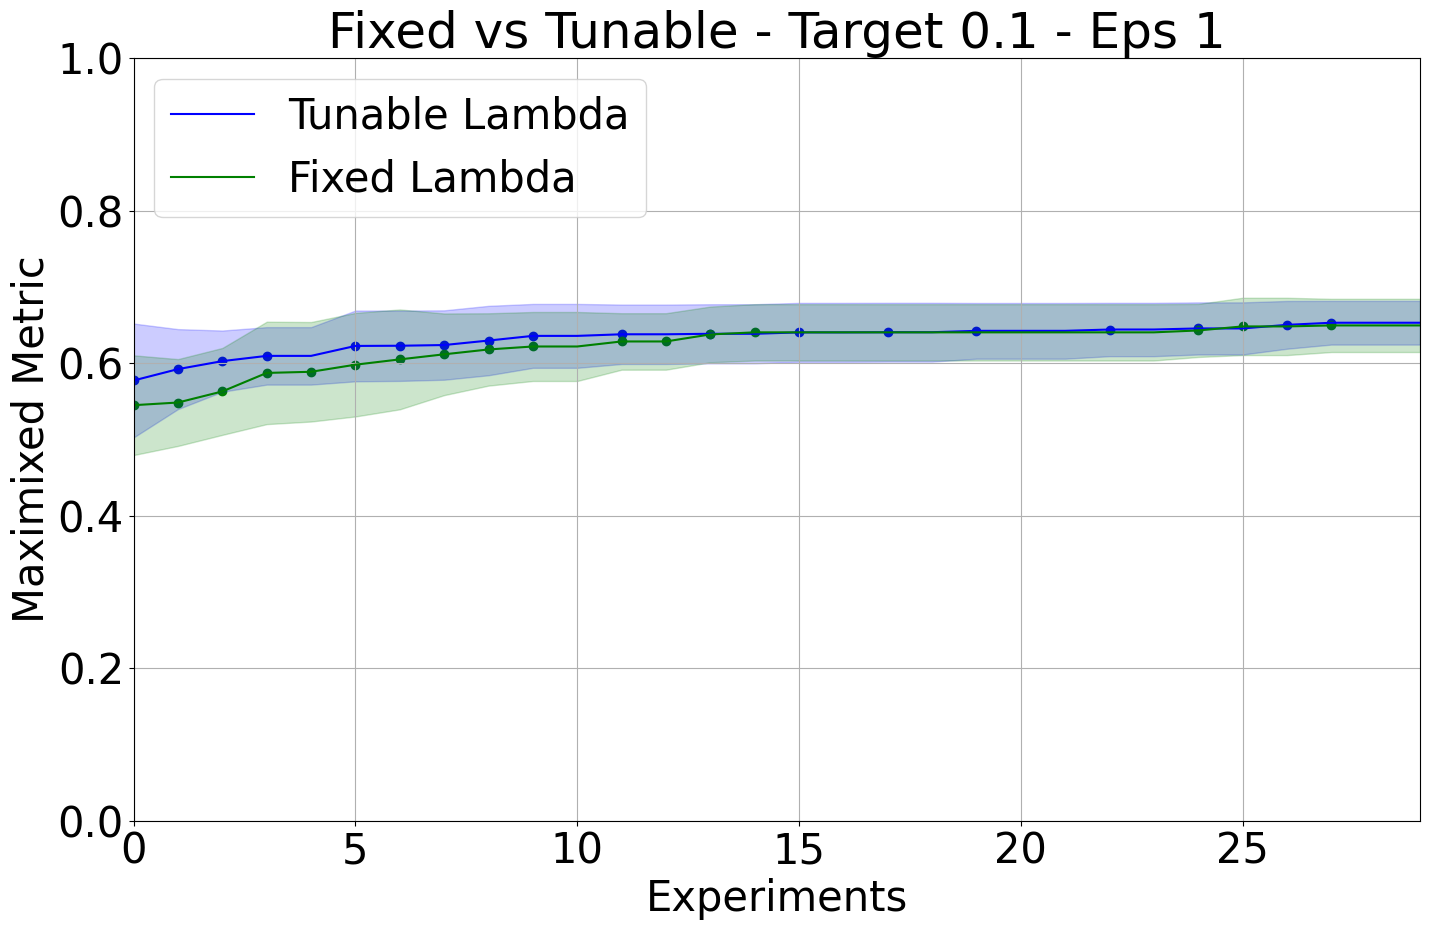

In [10]:
project_name = "Dutch_01_epsilon_1"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_1,
    target=0.1,
    project_name=project_name,
    epsilon=1,
)

# Target 0.1 Epsilon 0.5

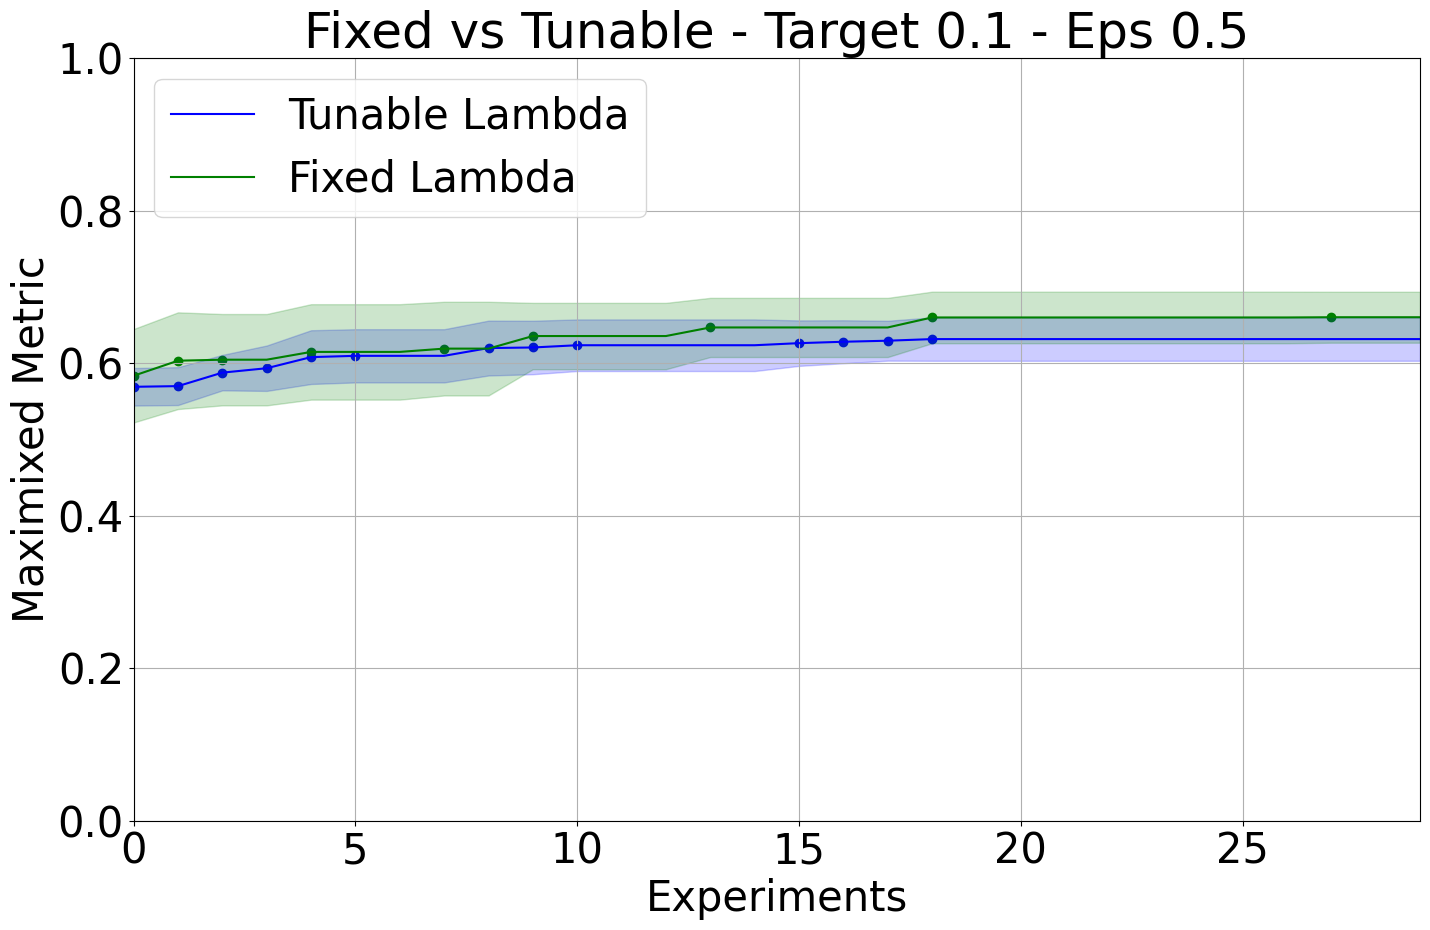

In [11]:
project_name = "Dutch_01_epsilon_05"
data = download_data(project_name)
manage_plots(
    data=data,
    data_baseline=data_baseline_05,
    target=0.1,
    project_name=project_name,
    epsilon=0.5,
)